In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import struct
from pathlib import Path
from tqdm import tqdm
import os
os.chdir('/media/data2/samba/xjlab/MEA/')

In [2]:
def writeABF1(sweepData, filename, sampleRateHz, units='pA'):
    """
    Create an ABF1 file from scratch and write it to disk.
    Files created with this function are compatible with MiniAnalysis.
    Data is expected to be a 2D numpy array (each row is a sweep).
    Credit to pyABF
    """

    assert isinstance(sweepData, np.ndarray)

    # constants for ABF1 files
    BLOCKSIZE = 512
    HEADER_BLOCKS = 4

    # determine dimensions of data
    sweepCount = sweepData.shape[0]
    sweepPointCount = sweepData.shape[1]
    dataPointCount = sweepPointCount*sweepCount

    # predict how large our file must be and create a byte array of that size
    bytesPerPoint = 2
    dataBlocks = int(dataPointCount * bytesPerPoint / BLOCKSIZE) + 1
    data = bytearray((dataBlocks + HEADER_BLOCKS) * BLOCKSIZE)

    # populate only the useful header data values
    struct.pack_into('4s', data, 0, b'ABF ')  # fFileSignature
    struct.pack_into('f', data, 4, 1.3)  # fFileVersionNumber
    struct.pack_into('h', data, 8, 5)  # nOperationMode (5 is episodic)
    struct.pack_into('i', data, 10, dataPointCount)  # lActualAcqLength
    struct.pack_into('i', data, 16, sweepCount)  # lActualEpisodes
    struct.pack_into('i', data, 40, HEADER_BLOCKS)  # lDataSectionPtr
    struct.pack_into('h', data, 100, 0)  # nDataFormat is 1 for float32
    struct.pack_into('h', data, 120, 1)  # nADCNumChannels
    struct.pack_into('f', data, 122, 1e6 / sampleRateHz)  # fADCSampleInterval
    struct.pack_into('i', data, 138, sweepPointCount)  # lNumSamplesPerEpisode

    # These ADC adjustments are used for integer conversion. It's a good idea
    # to populate these with non-zero values even when using float32 notation
    # to avoid divide-by-zero errors when loading ABFs.

    fSignalGain = 1  # always 1
    fADCProgrammableGain = 1  # always 1
    lADCResolution = 2**15  # 16-bit signed = +/- 32768

    # determine the peak data deviation from zero
    maxVal = np.max(np.abs(sweepData))

    # set the scaling factor to be the biggest allowable to accommodate the data
    fInstrumentScaleFactor = 100
    for i in range(10):
        fInstrumentScaleFactor /= 10
        fADCRange = 10
        valueScale = lADCResolution / fADCRange * fInstrumentScaleFactor
        maxDeviationFromZero = 32767 / valueScale
        if (maxDeviationFromZero >= maxVal):
            break

    # prepare units as a space-padded 8-byte string
    unitString = units
    while len(unitString) < 8:
        unitString = unitString + " "

    # store the scale data in the header
    struct.pack_into('i', data, 252, lADCResolution)
    struct.pack_into('f', data, 244, fADCRange)
    for i in range(16):
        struct.pack_into('f', data, 922+i*4, fInstrumentScaleFactor)
        struct.pack_into('f', data, 1050+i*4, fSignalGain)
        struct.pack_into('f', data, 730+i*4, fADCProgrammableGain)
        struct.pack_into('8s', data, 602+i*8, unitString.encode())

    # fill data portion with scaled data from signal
    dataByteOffset = BLOCKSIZE * HEADER_BLOCKS
    for sweepNumber, sweepSignal in enumerate(sweepData):
        sweepByteOffset = sweepNumber * sweepPointCount * bytesPerPoint
        for valueNumber, value in enumerate(sweepSignal):
            valueByteOffset = valueNumber * bytesPerPoint
            bytePosition = dataByteOffset + sweepByteOffset + valueByteOffset
            struct.pack_into('h', data, bytePosition, int(value*valueScale))

    # save the byte array to disk
    with open(filename, 'wb') as f:
        f.write(data)
    return

def read_native_format(filename):
    with open(filename, 'rb') as f:
        # === 1. Read global header ===
        global_header_fmt = '<iiBdddd64BhBBihq'
        global_header_size = struct.calcsize(global_header_fmt)
        global_header_data = f.read(global_header_size)
        if len(global_header_data) < global_header_size:
            raise ValueError("File too short to contain a valid global header.")

        unpacked = struct.unpack(global_header_fmt, global_header_data)
        (num_traces, blocks_per_trace, version_num,
         sampling_freq, trace_duration, voltage_range,
         short_to_mv_factor, *rest) = unpacked

        active_channels = rest[:64]
        (start_year, start_month, start_day,
         start_millis, timezone_offset, start_datetime64) = rest[64:]

        num_active_channels = sum(active_channels)
        if num_active_channels == 0:
            raise ValueError("No active channels found in global header.")

        # === 2. Read data blocks ===
        blocks = []
        while True:
            block_header_fmt = '<iiddiBBib'
            block_header_size = struct.calcsize(block_header_fmt)
            block_header_data = f.read(block_header_size)
            if not block_header_data or len(block_header_data) < block_header_size:
                break  # Reached EOF

            (trace_num, block_num, trace_offset_ms, block_offset_ms,
             num_data_points, is_first_block, is_last_block,
             stim_loop_num, stim_step_num) = struct.unpack(block_header_fmt, block_header_data)

            # Read size of data block (int32)
            size_bytes_data = f.read(4)
            if len(size_bytes_data) < 4:
                raise ValueError("Unexpected EOF while reading block size.")
            size_of_block_bytes = struct.unpack('<i', size_bytes_data)[0]

            # Read raw data block as int16 array
            raw_data = f.read(size_of_block_bytes)
            if len(raw_data) < size_of_block_bytes:
                raise ValueError("Unexpected EOF while reading data block.")

            block_data_flat = np.frombuffer(raw_data, dtype='<i2')  # little-endian int16
            num_samples = len(block_data_flat) // num_active_channels

            if len(block_data_flat) % num_active_channels != 0:
                raise ValueError(f"Data block size {len(block_data_flat)} not divisible by number of active channels {num_active_channels}.")

            block_data = block_data_flat.reshape((num_samples, num_active_channels))

            # Store block info
            blocks.append({
                'trace_num': trace_num,
                'block_num': block_num,
                'trace_offset_ms': trace_offset_ms,
                'block_offset_ms': block_offset_ms,
                'num_data_points': num_data_points,
                'is_first_block': bool(is_first_block),
                'is_last_block': bool(is_last_block),
                'stim_loop_num': stim_loop_num,
                'stim_step_num': stim_step_num,
                'data': block_data  # (samples, active_channels)
            })

    return {
        'global_header': {
            'num_traces': num_traces,
            'blocks_per_trace': blocks_per_trace,
            'version_num': version_num,
            'sampling_freq': sampling_freq,
            'trace_duration': trace_duration,
            'voltage_range': voltage_range,
            'short_to_mv_factor': short_to_mv_factor,
            'active_channels': active_channels,
            'start_year': start_year,
            'start_month': start_month,
            'start_day': start_day,
            'start_millis': start_millis,
            'timezone_offset': timezone_offset,
            'start_datetime64': start_datetime64
        },
        'blocks': blocks
    }
def convert_med64_to_abf(filename, output=None):
    if output == None:
        output = filename[:-6]+'.abf'
    med64_data = read_native_format(filename)
    matrix = med64_data['blocks'][0]['data'].T
    for i in tqdm(range(1,len(med64_data['blocks']))):
        matrix = np.append(matrix, med64_data['blocks'][i]['data'].T,axis=1)
    matrix = matrix*med64_data['global_header']['short_to_mv_factor']
    freq = med64_data['global_header']['sampling_freq']
    print(filename, ' coverting....')
    writeABF1(matrix,
              output, 
              freq,
              units='mV')
    print('Done')

In [3]:
import glob
listfiles = glob.glob('demo/*.modat')
for file in listfiles:
    convert_med64_to_abf(file)

100%|██████████| 19/19 [00:00<00:00, 463.47it/s]


demo/demo.modat  coverting....
Done


100%|██████████| 19/19 [00:00<00:00, 713.45it/s]


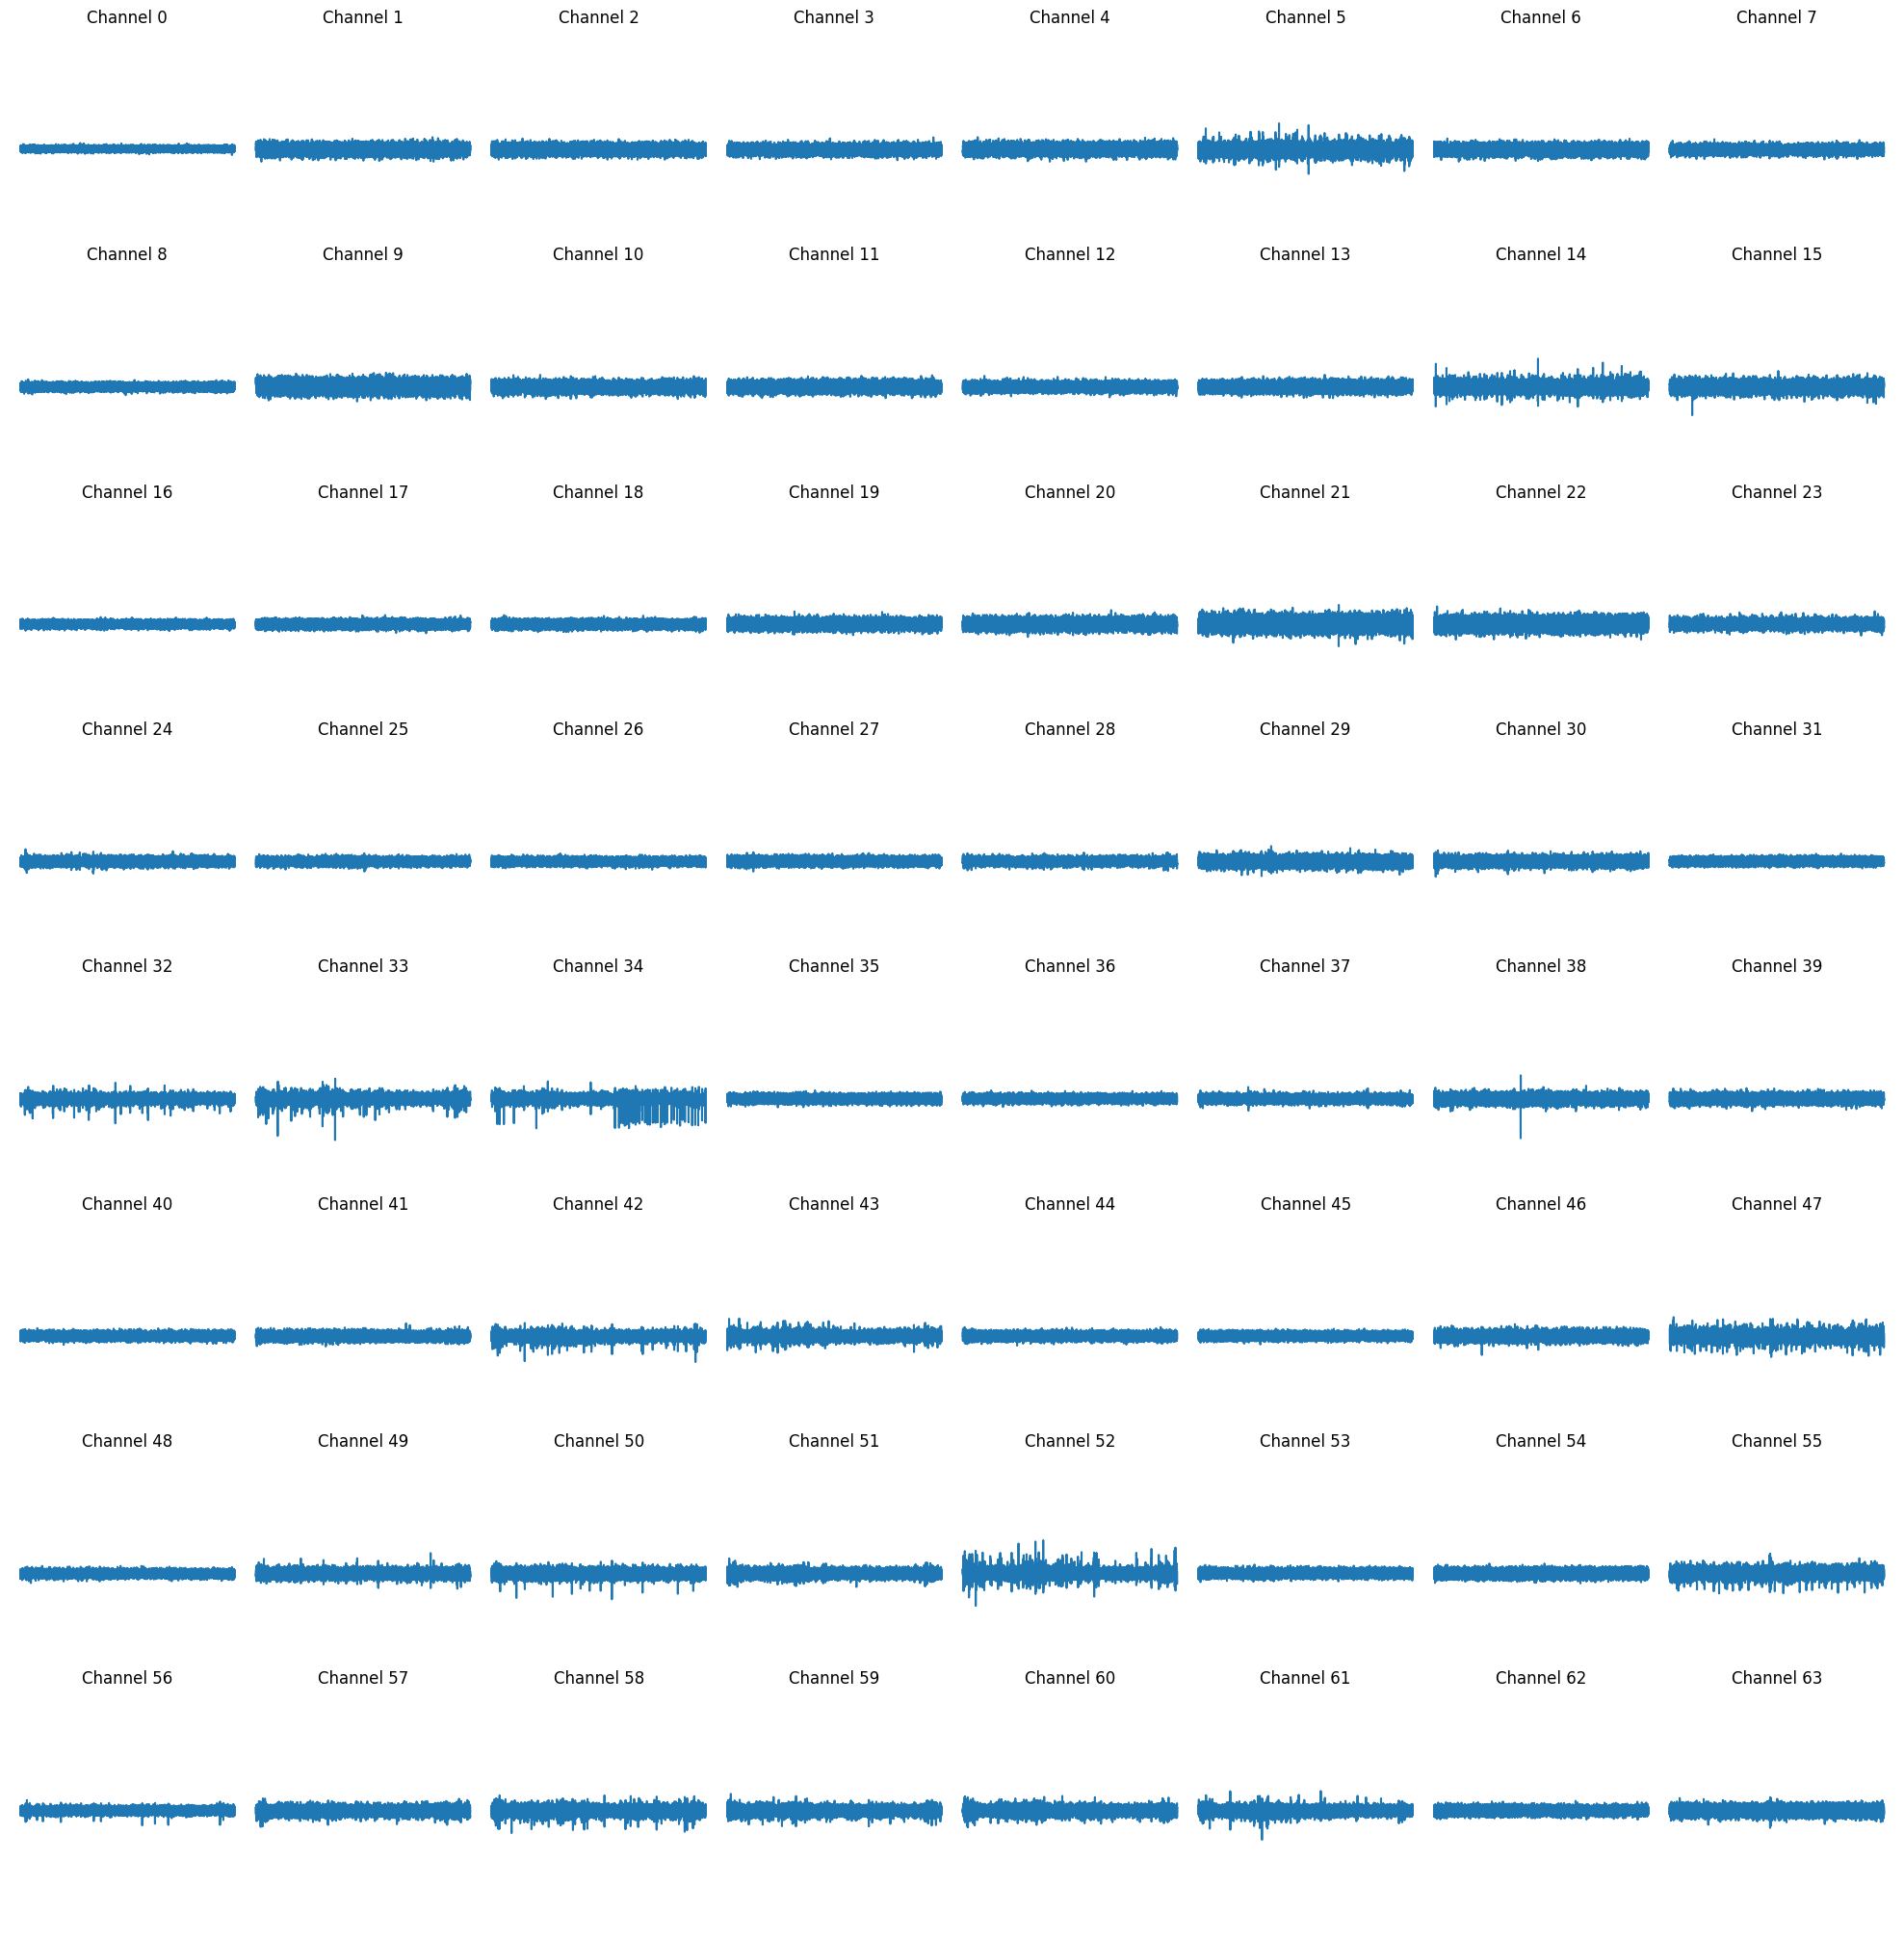

In [4]:
filename = 'demo/demo.modat'
med64_data = read_native_format(filename)
matrix = med64_data['blocks'][0]['data'].T
for i in tqdm(range(1,len(med64_data['blocks']))):
    matrix = np.append(matrix, med64_data['blocks'][i]['data'].T,axis=1)
matrix = matrix*med64_data['global_header']['short_to_mv_factor']
matrix_pre = matrix

fig, axes = plt.subplots(8, 8, figsize=(20, 20))  # Adjust figsize as needed
fig.tight_layout(pad=0,h_pad=0,w_pad=0)
axes = axes.flatten()
start = 5 # seconds
end = 10 # seconds
start = int(start*med64_data['global_header']['sampling_freq'])
end = int(end*med64_data['global_header']['sampling_freq'])
for i in range(64):
    ax = axes[i]
    ax.plot(matrix[i,start:end])  # plot the i-th row
    ax.set_title(f'Channel {i}')
    ax.axis('off')  # Optional: hide axes for cleaner look
    ax.set_ylim([-0.05,0.05]) 
fig.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()